In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 디바이스 설정
import tensorflow as tf
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16,7
plt.rc('font', family='NanumBarunGothic')

In [4]:
sp500 = pd.read_csv('/content/drive/My Drive/데이터/S&P_170103_final.csv')

In [5]:
print(sp500.shape) #815 94
sp500.tail() # rv5 sqrt 한 것이 RV

(909, 5)


,date,snp,snp500,rv5,RV
904,2020-08-17,25.23,25.20,0.000008,0.002907
905,2020-08-18,29.00,25.76,0.000033,0.005748
906,2020-08-19,26.10,28.00,0.000030,0.005488
907,2020-08-20,25.23,26.32,0.000018,0.004251
908,2020-08-21,26.68,24.92,0.000019,0.004413


In [6]:
y = pd.DataFrame(sp500.RV.values[1:])
RV_d = pd.DataFrame(sp500.RV[:-1].values)
RV_w = pd.DataFrame(sp500.RV.rolling(5).mean()[:-1].values)
RV_m = pd.DataFrame(sp500.RV.rolling(22).mean()[:-1].values)

In [7]:
sp500_RV = pd.concat([RV_d, RV_w, RV_m, y], axis=1).dropna()
sp500_RV.columns = ['rv_d', 'rv_w', 'rv_m', 'y']

In [8]:
sp500_RV 

,rv_d,rv_w,rv_m,y
21,0.004020,0.003949,0.003819,0.002837
22,0.002837,0.004002,0.003678,0.002499
23,0.002499,0.003606,0.003626,0.002756
24,0.002756,0.003330,0.003595,0.003490
25,0.003490,0.003120,0.003578,0.002516
...,...,...,...,...
903,0.005776,0.006365,0.006691,0.002907
904,0.002907,0.005808,0.006326,0.005748
905,0.005748,0.005031,0.006247,0.005488
906,0.005488,0.005014,0.006264,0.004251


In [9]:
def train_test_split(data, p):
  num = int(len(data)*p)
  train = data[:num]
  test = data[num:]
  return train, test

In [10]:
train, test = train_test_split(sp500_RV, 0.9)

In [39]:
print(train.shape)
print(test.shape)

(798, 4)
(89, 4)


## HAR

In [12]:
import statsmodels.api as sm

X = train[['rv_d', 'rv_w', 'rv_m']]
X = sm.add_constant(X)
y = train['y']

model = sm.OLS(y, X).fit()

# Print out the statistics
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     1001.
Date:                Sun, 02 May 2021   Prob (F-statistic):          3.57e-269
Time:                        02:57:32   Log-Likelihood:                 3460.3
No. Observations:                 798   AIC:                            -6913.
Df Residuals:                     794   BIC:                            -6894.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      3.586      0.000       0.000       0.001
rv_d           0.4376      0.044     10.032      0.000       0.352       0.523
rv_w           0.5769      0.059      9.739      0.000       0.461       0.693
rv_m          -0.1110      0.041     -2.731      0.006      -0.191      -0.031
==============================================================================
Omnibus:                      703.564   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52373.002
Skew:                           3.554   Prob(JB):                         0.00
Kurtosis:                      42.046   Cond. No.                         666.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
X = test[['rv_d', 'rv_w', 'rv_m']]
X = sm.add_constant(X)
predict_har = model.predict(X)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


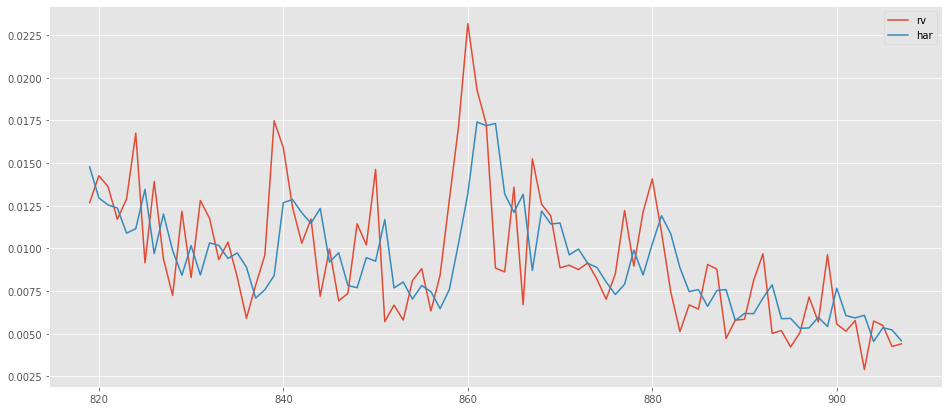

In [14]:
plt.plot(test.y, label='rv')
plt.plot(predict_har, label='har')
plt.legend()

In [15]:
def return_mse(y, predict):
  mse = np.mean((y-predict)**2)
  return mse

In [16]:
return_mse(test.y, predict_har)

1.0060367805013861e-05

## LSTM

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [34]:
def split_xy3(dataset, time_steps, y_column):
  x, y = list(), list()
  for i in range(len(dataset)):
    x_end_number = i + time_steps
    y_end_number = x_end_number + y_column - 1
    if y_end_number > len(dataset):
      break
    tmp_x = dataset[i:x_end_number, :-1]
    tmp_y = dataset[x_end_number-1:y_end_number, -1]
    x.append(tmp_x)
    y.append(tmp_y)
  return np.array(x), np.array(y)

In [36]:
x, y = split_xy3(np.array(sp500_RV[['rv_d', 'y']]), 22, 1)

In [37]:
print(x.shape)
print(y.shape)

(866, 22, 1)
(866, 1)


In [52]:
x_train = x[:777,:,:]
y_train = y[:777,:]
x_test = x[777:,:,:]
y_test = y[777:,:]

In [22]:
model = Sequential()
model.add(LSTM(64, input_shape=(22, 1)))
model.add(Dense(1))

In [46]:
model.compile(optimizer='adam', loss='mse')
model.fit(x_train, y_train, epochs=20, batch_size=1)

Epoch 1/20
777/777 [==============================] - 17s 2ms/step - loss: 3.3265e-05
Epoch 2/20
777/777 [==============================] - 2s 2ms/step - loss: 2.7138e-05
Epoch 3/20
777/777 [==============================] - 2s 2ms/step - loss: 2.0078e-05
Epoch 4/20
777/777 [==============================] - 2s 2ms/step - loss: 1.8912e-05
Epoch 5/20
777/777 [==============================] - 2s 2ms/step - loss: 1.8687e-05
Epoch 6/20
777/777 [==============================] - 2s 2ms/step - loss: 1.1477e-05
Epoch 7/20
777/777 [==============================] - 2s 2ms/step - loss: 1.2096e-05
Epoch 8/20
777/777 [==============================] - 2s 2ms/step - loss: 1.4462e-05
Epoch 9/20
777/777 [==============================] - 2s 2ms/step - loss: 1.1203e-05
Epoch 10/20
777/777 [==============================] - 2s 2ms/step - loss: 1.2420e-05
Epoch 11/20
777/777 [==============================] - 2s 2ms/step - loss: 1.0976e-05
Epoch 12/20
777/777 [==============================] - 2s 2ms/

In [56]:
predict_lstm = model.predict(x_test)

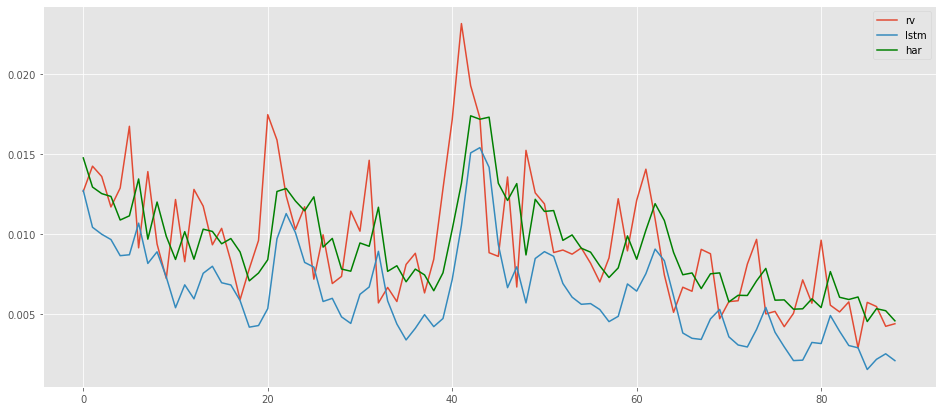

In [73]:
plt.plot(test.y.values, label='rv')
plt.plot(predict_lstm, label='lstm')
plt.plot(predict_har.values, label='har', color='green')
plt.legend()

In [104]:
mse_lstm = return_mse(y_test, predict_lstm)
mse_har = return_mse(y_test, predict_har.values)
pd.DataFrame({'lstm':mse_lstm, 'har':mse_har}, index=['mse'])

,lstm,har
mse,0.00002,0.000023
